In [1]:
import os
import torch
from torch import nn
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from torch.optim import AdamW,Adam
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [2]:
data_path = '/home/se/paper/legacy/data'

In [3]:
from sklearn.preprocessing import LabelEncoder
class StatDataset(Dataset):
    def __init__(self, match,stat,le):
        
        tmp = []
        label = []
        
        for home_pitcher,home_team,away_pitcher,away_team,home_result in list(zip(match['home_pitcher'].values,match['home'].values,match['away_pitcher'],match['away'],match['home_result'])):
            home_player_stat = stat.loc[(stat['name'] == home_pitcher) & (stat['team'] == home_team)]
            away_player_stat = stat.loc[(stat['name'] == away_pitcher) & (stat['team'] == away_team)]

            if (len(home_player_stat) != 0) and (len(away_player_stat) != 0):
                vector = home_player_stat.values.tolist()[0][2:] + away_player_stat.values.tolist()[0][2:]
                tmp.append(vector)
                label.append(home_result)
        
        transform = le.transform(label)
        self.label = torch.tensor(list(transform),dtype=torch.long)
        self.stat = torch.tensor(tmp)
            
    def __len__(self):
        return len(self.stat)

    def __getitem__(self, index):
        return {
                "stat": self.stat[index],
                "label": self.label[index]
                }
        
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [4]:
class legacyClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(legacyClassifier, self).__init__()
        self.linear1 = nn.Linear(36, 1024)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(1024,3)
        
    def forward(self, input_id):
        linear_output = self.linear1(input_id)
        dropout_output1 = self.dropout2(linear_output)
        linear_output1 = self.linear2(dropout_output1)
        return linear_output1

In [5]:
stat = pd.read_csv(os.path.join(data_path,'average.csv'))
match = pd.read_csv(os.path.join(data_path,'match_day.csv'))
le = LabelEncoder()
_=le.fit(['승','패','무승부'])

In [6]:
train_match,valid_match = train_test_split(match,shuffle=True,random_state=56)

In [7]:
train_dataset = StatDataset(train_match,stat,le)
valid_dataset = StatDataset(valid_match,stat,le)
print(len(train_dataset),len(valid_dataset))

576 189


In [8]:
batch_size = 16
epochs = 100
device='cuda'

In [9]:
le.classes_

array(['무승부', '승', '패'], dtype='<U3')

train_class = pd.DataFrame(train_dataset.label)
train_class_counts = [len(train_class.loc[train_class[0] == 0]) , len(train_class.loc[train_class[0] == 1])  , len(train_class.loc[train_class[0] == 2])]
train_num_samples = sum(train_class_counts)
train_labels = list(train_class.values.reshape(-1))

train_class_weights = [train_num_samples / train_class_counts[i] for i in range(len(train_class_counts))] 

# 해당 데이터의 label에 해당되는 가중치
train_weights = [train_class_weights[train_labels[i]] for i in range(int(train_num_samples))] #해당 레이블마다의 가중치 비율
train_sampler = WeightedRandomSampler(torch.DoubleTensor(train_weights), int(train_num_samples))

valid_class = pd.DataFrame(valid_dataset.label)
valid_class_counts = [len(valid_class.loc[train_class[0] == 0]) , len(valid_class.loc[train_class[0] == 1])  , len(valid_class.loc[train_class[0] == 2])]
valid_num_samples = sum(valid_class_counts)
valid_labels = list(valid_class.values.reshape(-1))

valid_class_weights = [valid_num_samples / valid_class_counts[i] for i in range(len(valid_class_counts))] 

# 해당 데이터의 label에 해당되는 가중치
valid_weights = [valid_class_weights[valid_labels[i]] for i in range(int(valid_num_samples))] #해당 레이블마다의 가중치 비율
valid_sampler = WeightedRandomSampler(torch.DoubleTensor(valid_weights), int(valid_num_samples))

train_class_weights

valid_class_weights

In [10]:
classifier = legacyClassifier()
classifier.cuda()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3)

In [11]:
criterion = nn.CrossEntropyLoss()
_=criterion.cuda()

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [13]:
train_loss = []
train_acc = []

valid_loss = []
valid_acc = []

In [14]:
classifier

legacyClassifier(
  (linear1): Linear(in_features=36, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=1024, out_features=3, bias=True)
)

In [15]:
count = []

In [16]:
classifier.zero_grad()
for epoch in tqdm(range(epochs),total=epochs):
    
    total_acc_train = 0
    total_loss_train = 0
    classifier.train()
    for i,batch in enumerate(train_dataloader):

        train_label = batch['label'].to(device)
        train_stat = batch['stat'].to(device)
        
        output = classifier(train_stat)
        output = output.squeeze(1)
        batch_loss = criterion(output.float(), train_label)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        total_loss_train += batch_loss.item()
        
        correct_prediction = torch.argmax(F.softmax(output, dim=1), 1) == train_label

        acc = correct_prediction.float().mean()
#         acc = (output.round() == train_label).sum().item()
        total_acc_train += acc.item()
        
    train_loss.append(total_loss_train/len(train_dataloader))
    train_acc.append(total_acc_train/len(train_dataloader))
            
    total_acc_val = 0
    total_loss_val = 0
    
    with  torch.no_grad():
        classifier.eval()
        cnt = [0,0,0]
        for i,batch in enumerate(val_dataloader):
            
            val_label = batch['label'].to(device)
            val_stat = batch['stat'].to(device)

            output = classifier(val_stat)
            output = output.squeeze(1)
            batch_loss = criterion(output.float(), val_label)
            
            total_loss_val += batch_loss.item()
            correct_prediction = torch.argmax(F.softmax(output, dim=1), 1) == val_label
            acc = correct_prediction.float().mean()
#             acc = (output.round() == val_label).sum().item()
            total_acc_val += acc.item()
            for value in torch.argmax(F.softmax(output, dim=1), 1):
                cnt[int(value.item())] += 1
        count.append(cnt)
        valid_loss.append(total_loss_val/ len(val_dataloader))
        valid_acc.append(total_acc_val/ len(val_dataloader))
#         torch.save(classifier.state_dict(), './model{}.pt'.format(epoch))
 
        print(
                f'Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_dataloader): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} \
                | Val Loss: {total_loss_val / len(val_dataloader): .3f} \
                | Val Accuracy: {total_acc_val / len(val_dataloader): .3f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  1.125                 | Train Accuracy:  0.497                 | Val Loss:  0.739                 | Val Accuracy:  0.566
Epochs: 2 | Train Loss:  1.002                 | Train Accuracy:  0.536                 | Val Loss:  0.869                 | Val Accuracy:  0.511
Epochs: 3 | Train Loss:  0.959                 | Train Accuracy:  0.510                 | Val Loss:  0.765                 | Val Accuracy:  0.518
Epochs: 4 | Train Loss:  1.032                 | Train Accuracy:  0.493                 | Val Loss:  0.795                 | Val Accuracy:  0.527
Epochs: 5 | Train Loss:  0.993                 | Train Accuracy:  0.491                 | Val Loss:  0.809                 | Val Accuracy:  0.523
Epochs: 6 | Train Loss:  0.919                 | Train Accuracy:  0.524                 | Val Loss:  0.759                 | Val Accuracy:  0.508
Epochs: 7 | Train Loss:  0.948                 | Train Accuracy:  0.503                 | Val Loss:  0.760                 |

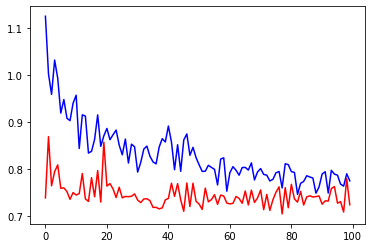

In [17]:
plt.plot(valid_loss,color='red',label = 'valid')
plt.plot(train_loss,color='blue',label = 'train')
plt.show()

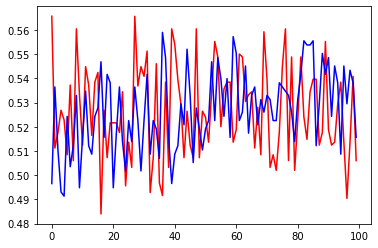

In [18]:
plt.plot(valid_acc,color='red',label = 'valid')
plt.plot(train_acc,color='blue',label = 'train')
plt.show()

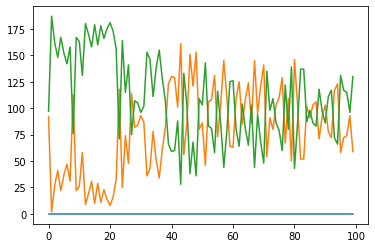

In [21]:
plt.plot(count)
plt.show()